In [1]:
!pip install seaborn

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from bisect import bisect
import seaborn as sns
from tqdm import tqdm

from dandi.dandiapi import DandiAPIClient
from collections import defaultdict

In [2]:
client = DandiAPIClient()

dandisets = list(client.get_dandisets())

neurodata_type_map = dict(
    ecephys=["LFP", "Units", "ElectricalSeries"],
    ophys=["PlaneSegmentation", "TwoPhotonSeries", "ImageSegmentation"],
    icephys=[
        "PatchClampSeries",
        "VoltageClampSeries",
        "CurrentClampSeries",
        "CurrentClampStimulusSeries",
    ],
)

def is_nwb(metadata):
    return any(
        x['identifier'] == 'RRID:SCR_015242'
        for x in metadata['assetsSummary'].get('dataStandard', {})
    )

def has_related_publication(metadata):
    return "relatedResource" in metadata and any(x.get("relation") == "dcite:IsDescribedBy" for x in metadata["relatedResource"])

data = defaultdict(list)
for dandiset in tqdm(dandisets):
    dandiset = dandiset.for_version("draft")
    identifier = dandiset.identifier
    metadata = dandiset.get_raw_metadata()
    
    if not is_nwb(metadata) or not dandiset.draft_version.size:
        continue
    data["identifier"].append(identifier)
    data["created"].append(dandiset.created)
    data["modified"].append(dandiset.modified)
    data["size"].append(dandiset.draft_version.size)
    if "species" in metadata["assetsSummary"] and len(metadata["assetsSummary"]["species"]):
        data["species"].append(metadata["assetsSummary"]["species"][0]["name"])
    else:
        data["species"].append(np.nan)
        
    data["nauthors"].append(
        sum(x.get('schemaKey',[]) == "Person" for x in metadata["contributor"]) if "contributor" in metadata else 0
    )
    
    
    for modality, ndtypes in neurodata_type_map.items():
        data[modality].append(
            any(x in ndtypes for x in metadata["assetsSummary"]["variableMeasured"])
        )
    
    data["numberOfSubjects"].append(metadata["assetsSummary"].get("numberOfSubjects", np.nan))
    data["numberOfFiles"].append(metadata["assetsSummary"].get("numberOfFiles", np.nan))        
    data["has_related_pub"].append(has_related_publication(metadata))
    
df = pd.DataFrame.from_dict(data)

100%|██████████| 296/296 [00:18<00:00, 16.22it/s]


In [3]:
species_replacement = {
    "Mus musculus - House mouse": "House mouse",
    "Rattus norvegicus - Norway rat": "Rat",
    "Brown rat": "Rat",
    "Rat; norway rat; rats; brown rat": "Rat",
    "Homo sapiens - Human": "Human",
    "Drosophila melanogaster - Fruit fly": "Fruit fly",
    "Danio rerio - Leopard danio": "Zebrafish",
    "Macaca mulatta - Rhesus monkey": "Rhesus monkey",
    "Danio rerio - Zebra fish": "Zebrafish",
    "Macaca nemestrina - Pig-tailed macaque": "Pig-tailed macaque",
    "Cricetulus griseus - Cricetulus aureus": "Chinese hamster",
    "Caenorhabditis elegans": "C. elegans",
    "Canis lupus familiaris - Dog": "Dog",
    "Oryctolagus cuniculus - Rabbits": "Rabbit",
    "Bos taurus - Cattle": "Cattle",
    "Macaca nemestrina - Pigtail macaque": "Pigtail macaque",
    "Ooceraea biroi - Clonal raider ant": "Clonal raider ant",
}

for key, val in species_replacement.items():
    df["species"] = df["species"].replace(key, val)

df

,identifier,created,modified,size,species,nauthors,ecephys,ophys,icephys,numberOfSubjects,numberOfFiles,has_related_pub
0,000003,2020-03-15 22:56:55.655000+00:00,2020-11-06 17:20:30.673000+00:00,2559248010229,House mouse,3,True,False,False,16.0,101,True
1,000004,2020-03-16 21:48:04.265000+00:00,2020-10-03 07:01:25.356000+00:00,6197474020,Human,13,True,False,False,59.0,87,True
2,000005,2020-03-16 22:52:44.757000+00:00,2020-04-09 20:59:35.377000+00:00,46436686324,House mouse,4,True,False,True,55.0,148,True
3,000006,2020-03-17 13:30:38.667000+00:00,2020-04-09 21:00:01.759000+00:00,139600500,House mouse,2,True,False,False,12.0,53,True
4,000007,2020-03-17 15:01:40.811000+00:00,2022-11-22 00:21:36.001459+00:00,199439472,House mouse,8,True,False,False,13.0,54,True
...,...,...,...,...,...,...,...,...,...,...,...,...
167,000570,2023-06-29 20:25:43.159623+00:00,2023-07-05 17:42:52.656910+00:00,4628300559,Human,6,False,False,True,58.0,155,False
168,000574,2023-07-04 13:52:07.557094+00:00,2023-07-04 15:17:12.948762+00:00,13067234538,Human,8,True,False,False,9.0,37,False
169,000575,2023-07-04 17:07:21.531429+00:00,2023-07-04 17:07:21.531458+00:00,23228640,Human,6,True,False,False,13.0,18,False
170,000579,2023-07-10 21:58:09.569708+00:00,2023-07-21 20:06:56.359828+00:00,245591965505,House mouse,3,False,True,False,8.0,308,False


In [4]:
df["species"].unique()

array(['House mouse', 'Human', nan, 'Rat', 'Rhesus monkey', 'Fruit fly',
       'Zebrafish', 'Pig-tailed macaque', 'Chinese hamster', 'Dog',
       'Clonal raider ant', 'C. elegans', 'Rabbit', 'Cattle',
       'Pigtail macaque'], dtype=object)

In [5]:
df["species"].value_counts()

House mouse           78
Rat                   26
Human                 24
Rhesus monkey         11
Fruit fly              5
Zebrafish              5
Cattle                 4
C. elegans             3
Rabbit                 2
Pig-tailed macaque     1
Chinese hamster        1
Dog                    1
Clonal raider ant      1
Pigtail macaque        1
Name: species, dtype: int64

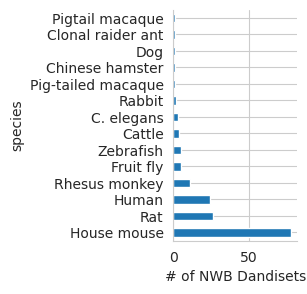

In [6]:
sns.set_style("whitegrid")

ax = df["species"].value_counts().plot.barh(figsize=(1.6, 3))
ax.set_xlabel("# of NWB Dandisets")
ax.set_ylabel("species")
sns.despine()
ax.figure.savefig(
    "species.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)


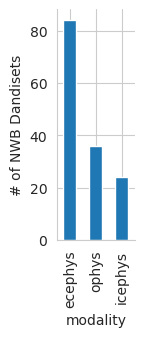

In [7]:
fig, ax = plt.subplots(figsize=(1, 3))

df[["ecephys", "ophys", "icephys"]].sum().plot.bar(ax=ax)
ax.set_xlabel("modality")
ax.set_ylabel("# of NWB Dandisets")
sns.despine()
ax.figure.savefig(
    "modality.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

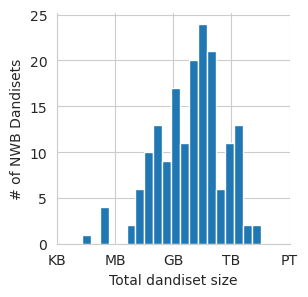

In [8]:
logsize = np.log10(df["size"])
#logsize[logsize < 0] = np.nan

fig, ax = plt.subplots(figsize=(3, 3))
ax = logsize.plot.hist(bins=20, ax=ax)
ax.set_xticks([3, 6, 9, 12, 15])
ax.set_xticklabels(["KB", "MB", "GB", "TB", "PT"])
ax.set_xlabel("Total dandiset size")
ax.set_ylabel("# of NWB Dandisets")
sns.despine()
ax.figure.savefig(
    "size.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [9]:
df["size"].sum()/(1e12)  #TB

102.283687884985

In [10]:
df["size"].sum()

102283687884985

In [11]:
len(df)

172

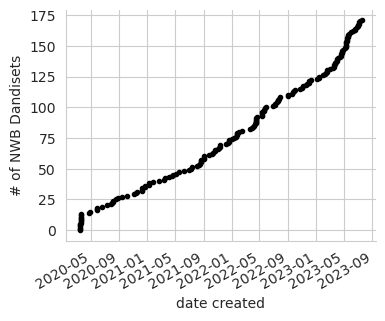

In [13]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(df['created'], np.arange(len(df)), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel('# of NWB Dandisets')
ax.set_xlabel("date created")
sns.despine()
ax.figure.savefig("date.png", bbox_inches="tight", dpi=300, transparent=True)

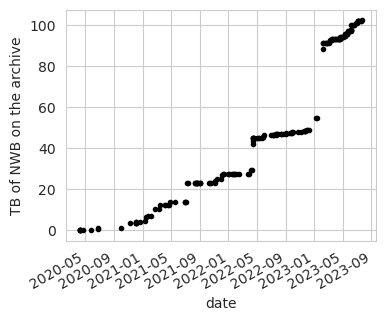

In [14]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], df['size'][order].cumsum()/10**12, '.k')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_xlabel("date")
_ = ax.set_ylabel("TB of NWB on the archive")

In [18]:
df.columns

Index(['identifier', 'created', 'modified', 'size', 'species', 'nauthors',
       'ecephys', 'ophys', 'icephys', 'numberOfSubjects', 'numberOfFiles',
       'has_related_pub'],
      dtype='object')

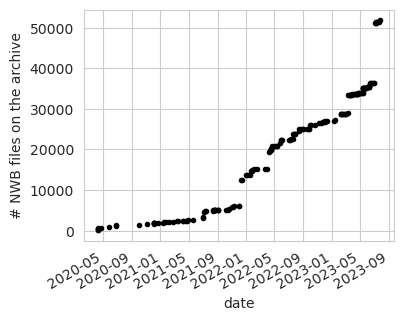

In [20]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], df['numberOfFiles'][order].cumsum(), '.k')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_xlabel("date")
_ = ax.set_ylabel("# NWB files on the archive")

[Text(0, 9, 'GB'), Text(0, 12, 'TB'), Text(0, 15, 'PB')]

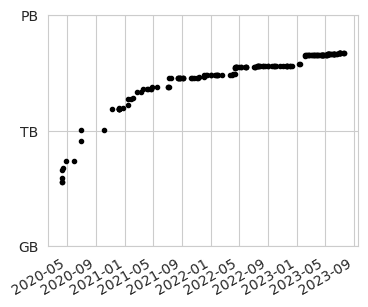

In [15]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], np.log10(df['size'][order].cumsum()), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_yticks([9,12,15])
ax.set_yticklabels(["GB", "TB", "PB"])

(12.0, 15.0)

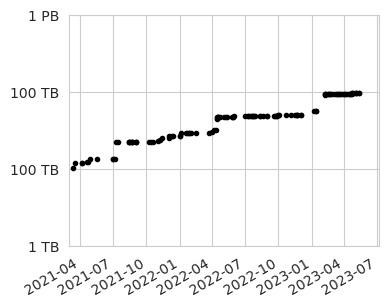

In [16]:
fig, ax = plt.subplots(figsize=(4,3))

order = np.argsort(df['modified'])

ax.plot(df['modified'][order], np.log10(df['size'][order].cumsum()), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_yticks([12, 13, 14, 15])
ax.set_yticklabels(["1 TB", "100 TB", "100 TB", "1 PB"])
ax.set_xlim(datetime(2021, 3, 1), None)
ax.set_ylim(12, 15)

In [17]:
date_idx = df['modified'][order].apply(lambda x: pd.to_datetime(x)).dt.date > datetime(2021,3,1).date()

In [18]:
seconds_in_a_day = 86400
days = (df['modified'][order]).apply(lambda x: (x.replace(tzinfo=None) - datetime(2021,3,1)).total_seconds()/seconds_in_a_day/365.25)

Text(0.5, 0, 'date')

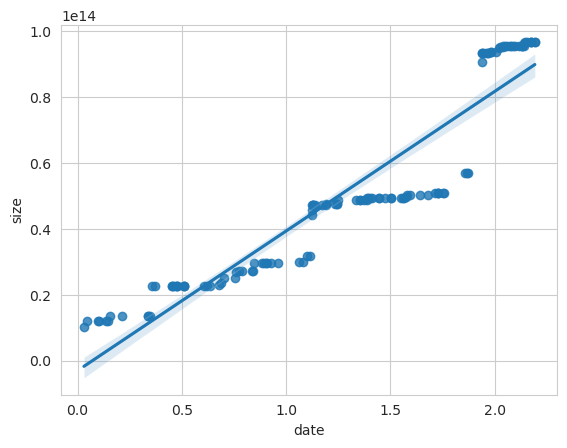

In [19]:
ax = sns.regplot(x=days[date_idx], y=df['size'][order].cumsum()[date_idx]);
ax.set_xlabel("date")
#ax.set_yticks([13, 14, 15])
#ax.set_yticklabels(["10 TB", "100 TB", "1 PB"])
#ax.set_yticks(12+np.log10(np.linspace(1,10,10)), minor=True)



Text(0, 0.5, 'total size (TB)')

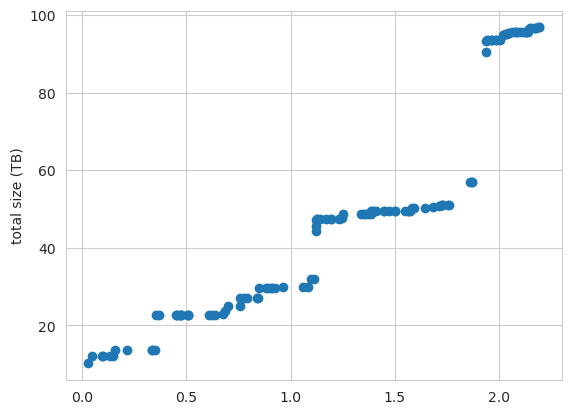

In [20]:
fig, ax = plt.subplots()
ax.plot(days[date_idx], df['size'][order].cumsum()[date_idx]/10**12, 'o')
ax.set_ylabel("total size (TB)")

(0.0, 3.0)

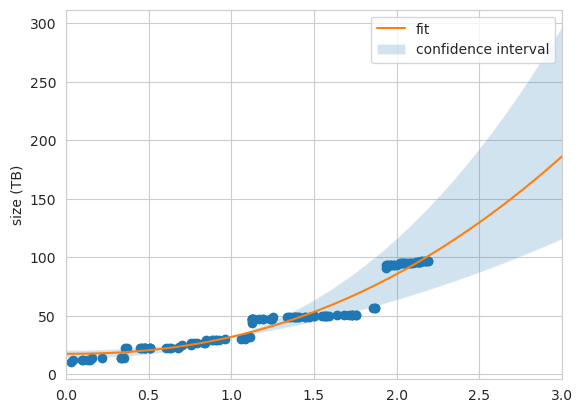

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

fig, ax = plt.subplots()


# define the power-law function to fit
def power_law_func(x, a, b, c):
    return a * x**b - c

popt, pcov = curve_fit(power_law_func, days[date_idx], df['size'][order].cumsum()[date_idx]/10**12)

# calculate the confidence intervals
perr = np.sqrt(np.diag(pcov))
confidence_interval = 1.96 * perr
lower_bound = popt - confidence_interval
upper_bound = popt + confidence_interval

# plot the result
x = np.linspace(0, 3, 100)
ax.plot(days[date_idx], df['size'][order].cumsum()[date_idx]/10**12, 'o')
ax.plot(x, power_law_func(x, *popt), label='fit')
ax.fill_between(x, power_law_func(x, *lower_bound), power_law_func(x, *upper_bound), alpha=0.2, label='confidence interval')
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
ax.set_ylabel("size (TB)")
ax.set_xlim(0,3)


In [200]:
12+np.log10(np.linspace(1,10,10))

array([12.        , 12.30103   , 12.47712125, 12.60205999, 12.69897   ,
       12.77815125, 12.84509804, 12.90308999, 12.95424251, 13.        ])

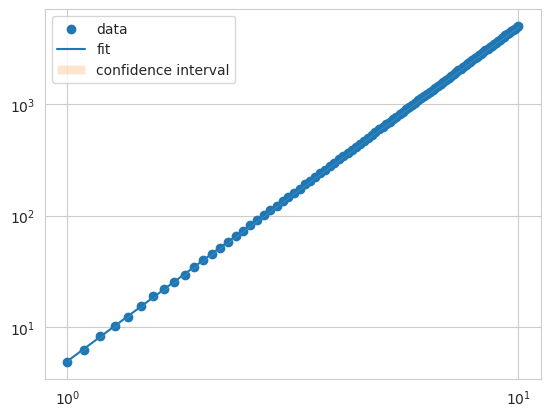

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# define the power-law function to fit
def power_law_func(x, a, b):
    return a * x**b

# generate some sample data
x = np.linspace(1, 10, 100)
y = 5 * x**(3) + np.random.normal(0, 0.2, size=len(x))

# fit the power-law function to the data
popt, pcov = curve_fit(power_law_func, x, y)

# calculate the confidence intervals
perr = np.sqrt(np.diag(pcov))
confidence_interval = 1.96 * perr
lower_bound = popt - confidence_interval
upper_bound = popt + confidence_interval

# plot the result
plt.scatter(x, y, label='data')
plt.plot(x, power_law_func(x, *popt), label='fit')
plt.fill_between(x, power_law_func(x, *lower_bound), power_law_func(x, *upper_bound), alpha=0.2, label='confidence interval')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


In [33]:
times = df['modified'][order]
days = (times - times.iloc[0]).apply(lambda x: x.total_seconds()/86400)

In [42]:
import scipy

x = days
y = df['size'][order].cumsum()

coefs, _ = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y)


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:862: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)


In [43]:
coefs

array([1., 1.])

In [59]:
[1000**x for x in range(2,6)]
["MB", "GB", "TB", "PB"]

['MB', 'GB', 'TB', 'PB']

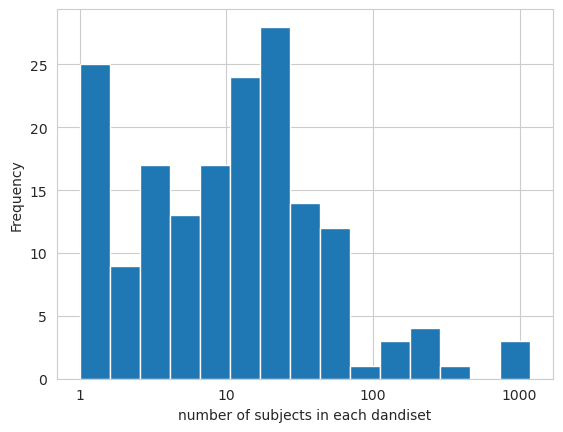

In [16]:
lognum = np.log10(df["numberOfSubjects"])


ax = lognum.plot.hist(bins=15)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([1, 10, 100, 1000])
ax.set_xlabel("number of subjects in each dandiset")
ax.figure.savefig("subjects.svg", bbox_inches="tight")

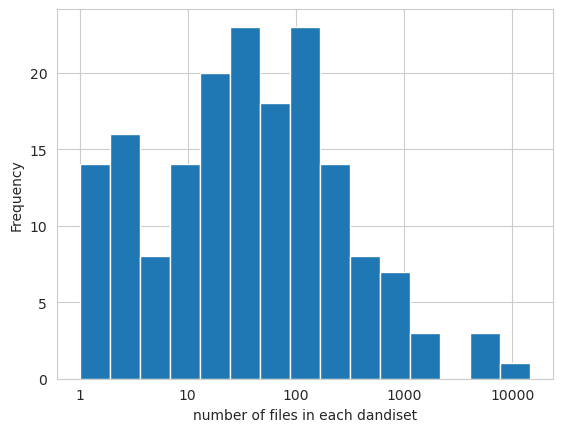

In [17]:
lognum = np.log10(df["numberOfFiles"])


ax = lognum.plot.hist(bins=15)
orders = np.arange(5)
ax.set_xticks(orders)
ax.set_xticklabels([10**x for x in orders])
ax.set_xlabel("number of files in each dandiset")
ax.figure.savefig("files.svg", bbox_inches="tight")

In [11]:
identifiers = df[
    (df["species"] == "House mouse") & 
    (df["numberOfSubjects"] > 40) & 
    (df["ecephys"] == True)
]["identifier"].values

In [91]:
# find only NWB files with male subjects

asset_list = []
for dandiset in dandisets:
    if dandiset.identifier not in identifiers:
        continue
    for asset in tqdm(list(dandiset.get_assets())):
        asset_metadata = asset.get_metadata()
        sex = asset_metadata.wasAttributedTo[0].sex
        if sex and sex.name == "Male":
            asset_list.append(asset)

100%|██████████| 513/513 [00:16<00:00, 30.31it/s]


In [92]:
len(asset_list)

660

In [79]:
asset.get_metadata().wasAttributedTo[0].sex